In [1]:
import pandas as pd
import geopandas as gpd
import shapely
from fiona.crs import from_epsg
import numpy as np
import urllib.request as request
import os
import sys
import matplotlib.pyplot as plt
try:
    from StringIO import BytesIO as io
except ImportError:
    from io import BytesIO as io
from urllib.parse import urlencode as urlencode
from urllib.request import urlopen as urlopen
from urllib.error import HTTPError as HTTPError
import ast
import statsmodels.formula.api as smf
try:
    from sklearn.model_selection import train_test_split
except ImportError:
    from sklearn.cross_validation import train_test_split
from sklearn import preprocessing, metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble  import RandomForestRegressor as rfr

%matplotlib inline

# 1. Collect and read data
### 1.1 Collect SAT data

In [2]:
# make sure puidata exists
puidata = os.getenv("PUIDATA")
if not puidata:   print("please set up env var PUIDATA")
else: print(puidata)

/nfshome/gw1054/PUIdata


In [3]:
# retreive and save the csv file
url = 'https://data.cityofnewyork.us/resource/734v-jeq5.csv'
satfile = puidata + '/' + "satScoresNYC.csv"
request.urlretrieve(url, satfile)

('/nfshome/gw1054/PUIdata/satScoresNYC.csv',
 <http.client.HTTPMessage at 0x7f1a89ca21d0>)

In [4]:
# read data into data frame
sat = pd.read_csv(satfile, names=['DBN', 'num_takers', 'SATreading', 'SATmath', 'SATwriting', 'school'], header=0)

# change columns to numeric for averaging
# and find average of all three test scores
for i in range(1, 5):
    sat.iloc[:, i] = pd.to_numeric(sat.iloc[:, i], errors='coerce')
sat['SATall'] = (sat['SATreading'] + sat['SATmath'] + sat['SATwriting']) / 3

# take only the needed columns
sat = sat[['DBN', 'SATmath', 'SATall']]
sat.head()

,DBN,SATmath,SATall
0,01M292,404.0,374.000000
1,01M448,423.0,390.666667
2,01M450,402.0,383.000000
3,01M458,401.0,391.333333
4,01M509,433.0,402.333333


## 1.2 Collect School Crime Data

In [5]:
# retreive and save the csv file
# url = 'https://data.cityofnewyork.us/resource/sm8b-9vim.csv'
url = 'https://data.cityofnewyork.us/api/views/qybk-bjjc/rows.csv?accessType=DOWNLOAD'
schoolfile = puidata + '/' + "schoolSafety.csv"
request.urlretrieve(url, schoolfile)

('/nfshome/gw1054/PUIdata/schoolSafety.csv',
 <http.client.HTTPMessage at 0x7f1a89c04278>)

In [6]:
school_safety = pd.read_csv(schoolfile)
school_safety.columns

Index(['School Year', 'Building Code', 'DBN', 'Location Name', 'Location Code',
       'Address', 'Borough', 'Geographical District Code', 'Register',
       'Building Name', '# Schools', 'Schools in Building', 'Major N', 'Oth N',
       'NoCrim N', 'Prop N', 'Vio N', 'ENGroupA', 'RangeA', 'AvgOfMajor N',
       'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N', 'AvgOfVio N',
       'Borough Name', 'Postcode', 'Latitude', 'Longitude', 'Community Board',
       'Council District ', 'Census Tract', 'BIN', 'BBL', 'NTA'],
      dtype='object')

In [7]:
for i in school_safety.columns:
    s = i.lower().replace(' ', '_')
    school_safety.rename(columns={i: s}, inplace=True)
school_safety.columns

Index(['school_year', 'building_code', 'dbn', 'location_name', 'location_code',
       'address', 'borough', 'geographical_district_code', 'register',
       'building_name', '#_schools', 'schools_in_building', 'major_n', 'oth_n',
       'nocrim_n', 'prop_n', 'vio_n', 'engroupa', 'rangea', 'avgofmajor_n',
       'avgofoth_n', 'avgofnocrim_n', 'avgofprop_n', 'avgofvio_n',
       'borough_name', 'postcode', 'latitude', 'longitude', 'community_board',
       'council_district_', 'census_tract', 'bin', 'bbl', 'nta'],
      dtype='object')

In [8]:
# a lot of duplicate schools over the years, group them and take the mean
# school_safety = school_safety.groupby('DBN', as_index=False).mean()
# school_safety.shape

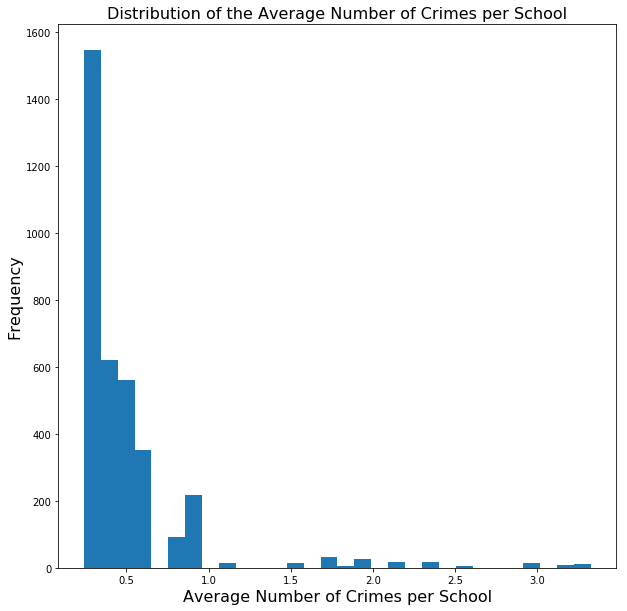

In [9]:
# plot distribution
fig = plt.figure(figsize=(10,10))
plt.hist(school_safety['avgofmajor_n'].dropna(), bins=30)
plt.xlabel('Average Number of Crimes per School', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title('Distribution of the Average Number of Crimes per School', fontsize=16)
plt.show()

***Caption [The distribution of the average number of major crimes is very skewed to the left which means that the average number of crimes per school is very low]***

# 2. Merge School Crime and SAT Data 
## 2.1 Merge Two Datasets

In [10]:
print(sat.columns)
print(school_safety.columns)

Index(['DBN', 'SATmath', 'SATall'], dtype='object')
Index(['school_year', 'building_code', 'dbn', 'location_name', 'location_code',
       'address', 'borough', 'geographical_district_code', 'register',
       'building_name', '#_schools', 'schools_in_building', 'major_n', 'oth_n',
       'nocrim_n', 'prop_n', 'vio_n', 'engroupa', 'rangea', 'avgofmajor_n',
       'avgofoth_n', 'avgofnocrim_n', 'avgofprop_n', 'avgofvio_n',
       'borough_name', 'postcode', 'latitude', 'longitude', 'community_board',
       'council_district_', 'census_tract', 'bin', 'bbl', 'nta'],
      dtype='object')


In [11]:
# merge to df on the dbn column
sat_crime = pd.merge(sat, school_safety, left_on='DBN', right_on='dbn')
sat_crime.head()

,DBN,SATmath,SATall,school_year,building_code,dbn,location_name,location_code,address,borough,...,borough_name,postcode,latitude,longitude,community_board,council_district_,census_tract,bin,bbl,nta
0,01M292,404.0,374.000000,2013-14,M056,01M292,Henry Street School for International Studies,M292,220 HENRY STREET,M,...,MANHATTAN,10002.0,40.713684,-73.986336,3.0,1.0,201.0,1003223.0,1.002690e+09,Lower East Side ...
1,01M292,404.0,374.000000,2014-15,M056,01M292,Henry Street School for International Studies,M292,220 HENRY STREET,M,...,MANHATTAN,10002.0,40.713684,-73.986336,3.0,1.0,201.0,1003223.0,1.002690e+09,Lower East Side ...
2,01M292,404.0,374.000000,2015-16,M056,01M292,Henry Street School for International Studies,M292,220 HENRY STREET,M,...,MANHATTAN,10002.0,40.713684,-73.986336,3.0,1.0,201.0,1003223.0,1.002690e+09,Lower East Side ...
3,01M448,423.0,390.666667,2013-14,M446,01M448,University Neighborhood High School,M448,200 MONROE STREET,M,...,MANHATTAN,10002.0,40.712399,-73.984497,3.0,1.0,202.0,1003214.0,1.002590e+09,Lower East Side ...
4,01M448,423.0,390.666667,2014-15,M446,01M448,University Neighborhood High School,M448,200 MONROE STREET,M,...,MANHATTAN,10002.0,40.712399,-73.984497,3.0,1.0,202.0,1003214.0,1.002590e+09,Lower East Side ...


In [12]:
print('sat shape ', sat.shape)
print('school crime shape ', school_safety.shape)
print('merged shape ', sat_crime.shape)

sat shape  (478, 3)
school crime shape  (6310, 34)
merged shape  (1359, 37)


In [13]:
print('crime data lost: ', (school_safety.shape[0] - sat_crime.shape[0]) / school_safety.shape[0])
print('sat data lost: ', (sat.shape[0] - sat_crime.shape[0]) / sat.shape[0])

crime data lost:  0.7846275752773375
sat data lost:  -1.8430962343096233


In this simple merge, most of data is lost

sat data lost ratio is negative because the original df is far smaller than the crime data df

## 2.2 Fill Missing Data

In [14]:
# replace all na with 0
# then drop the rows with 0 sat scores
sat_crime = sat_crime.fillna(0)
sat_crime = sat_crime[(sat_crime['SATmath'] > 0) & (sat_crime['SATall'] > 0)]
sat_crime.head()

,DBN,SATmath,SATall,school_year,building_code,dbn,location_name,location_code,address,borough,...,borough_name,postcode,latitude,longitude,community_board,council_district_,census_tract,bin,bbl,nta
0,01M292,404.0,374.000000,2013-14,M056,01M292,Henry Street School for International Studies,M292,220 HENRY STREET,M,...,MANHATTAN,10002.0,40.713684,-73.986336,3.0,1.0,201.0,1003223.0,1.002690e+09,Lower East Side ...
1,01M292,404.0,374.000000,2014-15,M056,01M292,Henry Street School for International Studies,M292,220 HENRY STREET,M,...,MANHATTAN,10002.0,40.713684,-73.986336,3.0,1.0,201.0,1003223.0,1.002690e+09,Lower East Side ...
2,01M292,404.0,374.000000,2015-16,M056,01M292,Henry Street School for International Studies,M292,220 HENRY STREET,M,...,MANHATTAN,10002.0,40.713684,-73.986336,3.0,1.0,201.0,1003223.0,1.002690e+09,Lower East Side ...
3,01M448,423.0,390.666667,2013-14,M446,01M448,University Neighborhood High School,M448,200 MONROE STREET,M,...,MANHATTAN,10002.0,40.712399,-73.984497,3.0,1.0,202.0,1003214.0,1.002590e+09,Lower East Side ...
4,01M448,423.0,390.666667,2014-15,M446,01M448,University Neighborhood High School,M448,200 MONROE STREET,M,...,MANHATTAN,10002.0,40.712399,-73.984497,3.0,1.0,202.0,1003214.0,1.002590e+09,Lower East Side ...


In [15]:
print('shape of the cleaned merged df ', sat_crime.shape)

shape of the cleaned merged df  (1202, 37)


after cleaning the missing values, rows of the data are lost

those are the rows with 0 sat socers

## 2.3 Count School Location

In [16]:
sat_crime.columns

Index(['DBN', 'SATmath', 'SATall', 'school_year', 'building_code', 'dbn',
       'location_name', 'location_code', 'address', 'borough',
       'geographical_district_code', 'register', 'building_name', '#_schools',
       'schools_in_building', 'major_n', 'oth_n', 'nocrim_n', 'prop_n',
       'vio_n', 'engroupa', 'rangea', 'avgofmajor_n', 'avgofoth_n',
       'avgofnocrim_n', 'avgofprop_n', 'avgofvio_n', 'borough_name',
       'postcode', 'latitude', 'longitude', 'community_board',
       'council_district_', 'census_tract', 'bin', 'bbl', 'nta'],
      dtype='object')

In [17]:
# groupby lat long and count the number of dbn in that latlong location
loc_cnt = sat_crime.groupby(['latitude', 'longitude'], as_index=False).count()
loc_cnt = loc_cnt[['latitude', 'longitude', 'DBN']]
np.unique(loc_cnt['DBN'])

array([ 1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 14, 15, 16, 18])

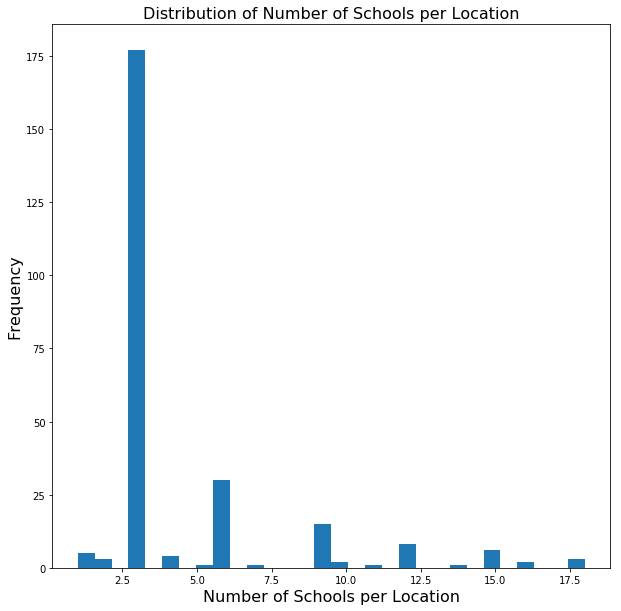

In [18]:
# plot distribution
fig = plt.figure(figsize=(10,10))
plt.hist(loc_cnt['DBN'].dropna(), bins=30)
plt.xlabel('Number of Schools per Location', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title('Distribution of Number of Schools per Location', fontsize=16)
plt.show()

***Caption [The distribution of number of schools is also skewed to the left, the average number of schools is very low] ***

# 3. Visualize School Data
## 3.1 Plot SATmath SATall Scores Against Number Major Crime and Average Number of Non-Criminal Crimes

In [19]:
# check the column and data types
for i in sat_crime.columns:
    print(i, type(sat_crime[i][0]))

DBN <class 'str'>
SATmath <class 'numpy.float64'>
SATall <class 'numpy.float64'>
school_year <class 'str'>
building_code <class 'str'>
dbn <class 'str'>
location_name <class 'str'>
location_code <class 'str'>
address <class 'str'>
borough <class 'str'>
geographical_district_code <class 'numpy.float64'>
register <class 'str'>
building_name <class 'str'>
#_schools <class 'numpy.int64'>
schools_in_building <class 'str'>
major_n <class 'numpy.float64'>
oth_n <class 'numpy.float64'>
nocrim_n <class 'numpy.float64'>
prop_n <class 'numpy.float64'>
vio_n <class 'numpy.float64'>
engroupa <class 'str'>
rangea <class 'str'>
avgofmajor_n <class 'numpy.float64'>
avgofoth_n <class 'numpy.float64'>
avgofnocrim_n <class 'numpy.float64'>
avgofprop_n <class 'numpy.float64'>
avgofvio_n <class 'numpy.float64'>
borough_name <class 'str'>
postcode <class 'numpy.float64'>
latitude <class 'numpy.float64'>
longitude <class 'numpy.float64'>
community_board <class 'numpy.float64'>
council_district_ <class 'numpy

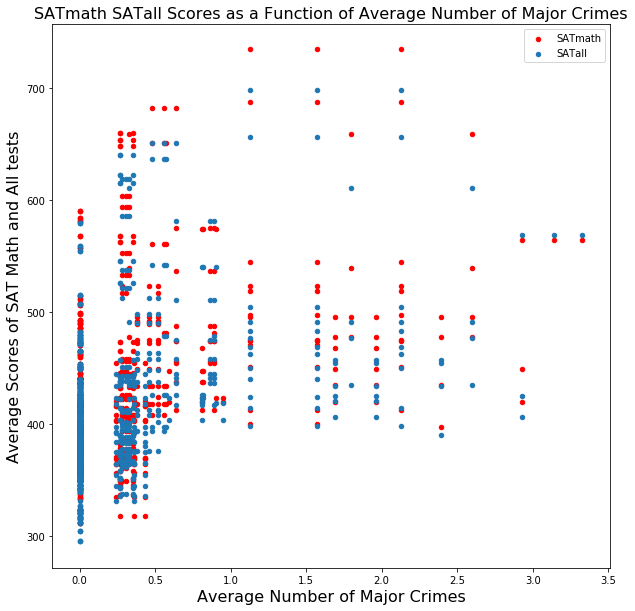

In [20]:
# plot data
fig, ax = plt.subplots(figsize=(10,10))
p1 = sat_crime.plot(x='avgofmajor_n', kind='scatter', y='SATmath', color='red', ax=ax, label='SATmath')
p4 = sat_crime.plot(x='avgofmajor_n', kind='scatter', y='SATall', ax=ax, label='SATall')
plt.xlabel('Average Number of Major Crimes', fontsize=16)
plt.ylabel('Average Scores of SAT Math and All tests', fontsize=16)
plt.title('SATmath SATall Scores as a Function of Average Number of Major Crimes', fontsize=16)
plt.legend()

***Caption [The scatter shows a potential positive linear relationship]***

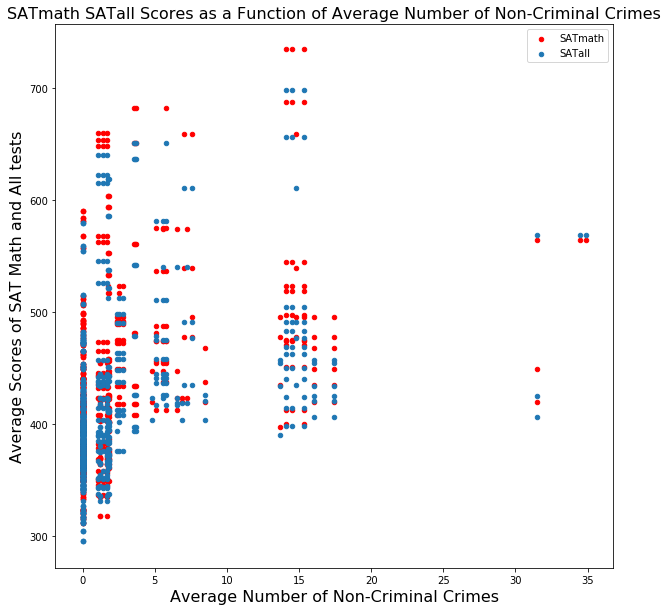

In [21]:
# plot data
fig, ax = plt.subplots(figsize=(10,10))
p1 = sat_crime.plot(x='avgofnocrim_n', kind='scatter', y='SATmath', color='red', ax=ax, label='SATmath')
p4 = sat_crime.plot(x='avgofnocrim_n', kind='scatter', y='SATall', ax=ax, label='SATall')
plt.xlabel('Average Number of Non-Criminal Crimes', fontsize=16)
plt.ylabel('Average Scores of SAT Math and All tests', fontsize=16)
plt.title('SATmath SATall Scores as a Function of Average Number of Non-Criminal Crimes', fontsize=16)
plt.legend()

***Caption [There is similar positive linear relationships] ***

## 3.2 Geometry from Coordinates and the School Locations

In [22]:
# transform sat_crime into a geodataframe
sat_crime['lonlat'] = list(zip(sat_crime['longitude'], sat_crime['latitude']))
sat_crime['geometry'] = sat_crime[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
geo_sc = gpd.GeoDataFrame(sat_crime)

# set to state plane
geo_sc.crs = from_epsg(4326)
geo_sc.to_crs(epsg=2263, inplace=True)

In [23]:
geo_sc.head()

,DBN,SATmath,SATall,school_year,building_code,dbn,location_name,location_code,address,borough,...,latitude,longitude,community_board,council_district_,census_tract,bin,bbl,nta,lonlat,geometry
0,01M292,404.0,374.000000,2013-14,M056,01M292,Henry Street School for International Studies,M292,220 HENRY STREET,M,...,40.713684,-73.986336,3.0,1.0,201.0,1003223.0,1.002690e+09,Lower East Side ...,"(-73.986336, 40.713684)",POINT (988037.9875462858 199291.1269536453)
1,01M292,404.0,374.000000,2014-15,M056,01M292,Henry Street School for International Studies,M292,220 HENRY STREET,M,...,40.713684,-73.986336,3.0,1.0,201.0,1003223.0,1.002690e+09,Lower East Side ...,"(-73.986336, 40.713684)",POINT (988037.9875462858 199291.1269536453)
2,01M292,404.0,374.000000,2015-16,M056,01M292,Henry Street School for International Studies,M292,220 HENRY STREET,M,...,40.713684,-73.986336,3.0,1.0,201.0,1003223.0,1.002690e+09,Lower East Side ...,"(-73.986336, 40.713684)",POINT (988037.9875462858 199291.1269536453)
3,01M448,423.0,390.666667,2013-14,M446,01M448,University Neighborhood High School,M448,200 MONROE STREET,M,...,40.712399,-73.984497,3.0,1.0,202.0,1003214.0,1.002590e+09,Lower East Side ...,"(-73.984497, 40.712399)",POINT (988547.8851731399 198823.0473264912)
4,01M448,423.0,390.666667,2014-15,M446,01M448,University Neighborhood High School,M448,200 MONROE STREET,M,...,40.712399,-73.984497,3.0,1.0,202.0,1003214.0,1.002590e+09,Lower East Side ...,"(-73.984497, 40.712399)",POINT (988547.8851731399 198823.0473264912)


In [24]:
# get puma
url = 'https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile'
filename = puidata + "/PUMA.zip"
request.urlretrieve(url, filename)

('/nfshome/gw1054/PUIdata/PUMA.zip',
 <http.client.HTTPMessage at 0x7f1a841ac400>)

In [25]:
!unzip -o $PUIDATA/PUMA.zip -d $PUIDATA

Archive:  /nfshome/gw1054/PUIdata/PUMA.zip
  inflating: /nfshome/gw1054/PUIdata/geo_export_05cb3c98-3487-4c9a-9f14-1f5507157490.dbf  
  inflating: /nfshome/gw1054/PUIdata/geo_export_05cb3c98-3487-4c9a-9f14-1f5507157490.shp  
  inflating: /nfshome/gw1054/PUIdata/geo_export_05cb3c98-3487-4c9a-9f14-1f5507157490.shx  
  inflating: /nfshome/gw1054/PUIdata/geo_export_05cb3c98-3487-4c9a-9f14-1f5507157490.prj  


In [26]:
puma = gpd.read_file(puidata + '/geo_export_f5693f78-058c-43af-84ea-14718ace7020.shp')
puma.to_crs(epsg=2263, inplace=True)

In [27]:
puma.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,..."
1,3702,1.889860e+08,106050.002302,"POLYGON ((1027331.841796877 256069.2766112776,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((1042822.450195312 243439.8142089319...
3,3704,1.062129e+08,47970.901277,"POLYGON ((1026308.769592285 256767.6972045382,..."
4,4015,8.105438e+07,50007.415493,"POLYGON ((997086.4570312516 171933.9880370507,..."


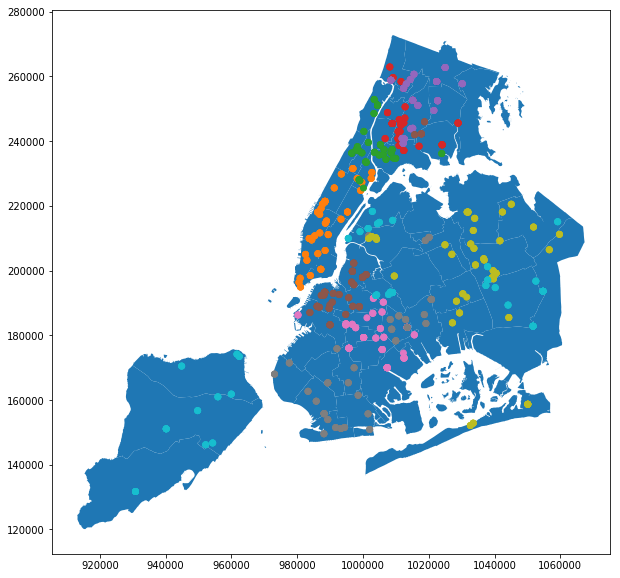

In [28]:
# there is a outlier that screws up the plot, remove it
geo_sc = geo_sc.loc[geo_sc['lonlat']!=geo_sc['lonlat'].max()]
fig, ax = plt.subplots(figsize=(10,10))
puma.plot(ax=ax)
geo_sc.plot(column='DBN', figsize=(10,10), ax=ax)

***Caption [The plot of the locations of schools in NYC]***

# 4 Asthma and Drugs Hospital Discharge Data
## 4.1 Read and Filter SPARCS Data

In [29]:
url = 'https://health.data.ny.gov/download/3m9u-ws8e/application%2Fzip'
filename = puidata + '/' + "SPARCS2012.zip"
request.urlretrieve(url, filename)

('/nfshome/gw1054/PUIdata/SPARCS2012.zip',
 <http.client.HTTPMessage at 0x7f1a865a7588>)

In [30]:
!unzip -o $PUIDATA/SPARCS2012.zip -d $PUIDATA

Archive:  /nfshome/gw1054/PUIdata/SPARCS2012.zip
  inflating: /nfshome/gw1054/PUIdata/NYSDOH_HospitalInpatientDischarges_SPARCS_De-Identified_2012.csv  
  inflating: /nfshome/gw1054/PUIdata/NYSDOH_SPARCS_De-Identified_2012_DataDictionary.pdf  
  inflating: /nfshome/gw1054/PUIdata/NYSDOH_SPARCS_De-Identified_2012_Overview.pdf  


In [31]:
sparcs = pd.read_csv(puidata + '/NYSDOH_HospitalInpatientDischarges_SPARCS_De-Identified_2012.csv')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [32]:
# check the shape of the df
sparcs.shape

(2544543, 38)

In [33]:
# keep data from NYC hospitals
nyc_counties = ['Kings', 'Queens', 'Manhattan', 'Bronx', 'Richmond']
sparcs = sparcs.loc[sparcs['Hospital County'].isin(nyc_counties)]

In [34]:
# check the sclicing result
np.unique(sparcs['Hospital County'])

array(['Bronx', 'Kings', 'Manhattan', 'Queens', 'Richmond'], dtype=object)

In [35]:
# compare data lose
# half of the dataframe is filtered out
print('original shape (2544543, 38) \ncurrent shape', sparcs.shape, '\nratio: ', sparcs.shape[0]/2544543)

original shape (2544543, 38) 
current shape (1199520, 38) 
ratio:  0.47140881486380853


a lot of the data is filtered out

In [36]:
# use 'CCS Diagnosis Description'
# keep asthma and drug related data
asthma = ['Asthma', 'Respiratory failure; insufficiency; arrest (adult)', 'Respiratory distress syndrome']
drug = ['Poisoning by psychotropic agents', 'Alcohol-related disorders', 'Substance-related disorders']
sparcs = sparcs.loc[sparcs['CCS Diagnosis Description'].isin(asthma) |
                    sparcs['CCS Diagnosis Description'].isin(drug)]

# convert the detailed diagnosis into broader types
sparcs['CCS Diagnosis Description'] = \
    sparcs['CCS Diagnosis Description'].apply(lambda x: 'Asthma' if x in (asthma) else 'Drug')

In [37]:
np.unique(sparcs['CCS Diagnosis Description'].astype(str))

array(['Asthma', 'Drug'], dtype=object)

In [38]:
# compare data lose
print('original shape (2544543, 38) \nshape after first slicing(1199520, 38)\ncurrent shape', sparcs.shape)
print('sliced data to original data ratio: ', 77053 / 2544543)

original shape (2544543, 38) 
shape after first slicing(1199520, 38)
current shape (77053, 38)
sliced data to original data ratio:  0.030281665509287917


## 4.2 Fractions of Asthma and Drug Relatted Issues

In [39]:
print("number of NYC discharges", sparcs.shape[0])

number of NYC discharges 77053


In [40]:
nycF = sparcs.groupby('Permanent Facility Id', as_index=False).count()
print("number of NYC facilities in the dataset", nycF.shape[0])

number of NYC facilities in the dataset 57


In [41]:
diag = sparcs.groupby('CCS Diagnosis Description').count()['Permanent Facility Id']
diag.head()

CCS Diagnosis Description
Asthma    30717
Drug      46336
Name: Permanent Facility Id, dtype: int64

In [42]:
nyca = diag.loc['Asthma']
print("number of asthma related cases in NYC", nyca) 

number of asthma related cases in NYC 30717


In [43]:
nycd = diag.loc['Drug']
print("number of drug related cases in NYC", nycd)

number of drug related cases in NYC 46336


In [44]:
# copy data with asthma 
# group by hospital and find the mean
temp = sparcs.copy()
asth = temp[temp['CCS Diagnosis Description'] == 'Asthma']
asth = asth.groupby(['Permanent Facility Id', 'CCS Diagnosis Description'], as_index=False).count()
asth = asth[['Permanent Facility Id', 'Hospital Service Area']]
asth['asthmaRatio'] = asth['Hospital Service Area'] / nyca
asth = asth.drop('Hospital Service Area', axis=1)

# repeat the same steps for data with drugs
drg = temp[temp['CCS Diagnosis Description'] == 'Drug']
drg = drg.groupby(['Permanent Facility Id', 'CCS Diagnosis Description'], as_index=False).count()
drg = drg[['Permanent Facility Id', 'Hospital Service Area']]
drg['drugsRatio'] = drg['Hospital Service Area'] / nycd
drg = drg.drop('Hospital Service Area', axis=1)

# merge the two datasets together
discharge = pd.merge(asth, drg, left_on='Permanent Facility Id', right_on='Permanent Facility Id')
discharge.head()

,Permanent Facility Id,asthmaRatio,drugsRatio
0,1165.0,0.036560,0.027603
1,1168.0,0.018882,0.021711
2,1169.0,0.068529,0.006971
3,1172.0,0.059446,0.013186
4,1176.0,0.029625,0.090146


In [45]:
discharge.shape

(52, 3)

## 4.3 Location of Each Facility

In [46]:
API_URL = 'https://fb55.carto.com:443/api/v2/sql?q='

def queryCartoDB(query, formatting = 'CSV', source = API_URL):
    '''queries carto datasets from a given carto account
    Arguments: 
    query - string: a valid sql query string
    format - outlut format  OPTIONAL (default CSV)
    source - a valid sql api endpoint OPTIONAL (default carto fb55 account)
    Returns:
    the return of the sql query AS A STRING
    NOTES:
    designed for the carto API, tested only with CSV return format'''
    
    
    data = urlencode({'format': formatting, 'q': query}).encode("utf-8")
    try:
        response = urlopen(source, data)
        return response.read()
    except HTTPError as e:
        raise (ValueError('\n'.join(ast.literal_eval(e.readline())['error'])))
        
def get_data(query):
    try:
        return pd.read_csv(io(queryCartoDB(query)), sep = ',')
    except ValueError as v:
        print (str(v))

In [47]:
query = '''SELECT facility_id, facility_latitude, facility_longitude FROM fb55.nyc_facilities
; '''
table = get_data(query)
table.head(5)

,facility_id,facility_latitude,facility_longitude
0,1320,40.654518,-73.945045
1,6448,40.653175,-73.886772
2,6754,40.689243,-73.956383
3,1206,40.846165,-73.904655
4,1207,40.814503,-73.919029


In [48]:
facility_location = pd.merge(discharge, table, left_on='Permanent Facility Id', right_on='facility_id')
facility_location.head()

,Permanent Facility Id,asthmaRatio,drugsRatio,facility_id,facility_latitude,facility_longitude
0,1165.0,0.036560,0.027603,1165,40.857388,-73.846741
1,1168.0,0.018882,0.021711,1168,40.894569,-73.861420
2,1169.0,0.068529,0.006971,1169,40.879951,-73.880562
3,1172.0,0.059446,0.013186,1172,40.817661,-73.924210
4,1176.0,0.029625,0.090146,1176,40.853909,-73.891014


In [49]:
facility_location.shape

(49, 6)

three rows of data is lost after the merge

# 5. Aggregate Data at PUMA Level
## 5.1 Get the PUMA Data and Plot

In [50]:
# puma data is already retreived at step 3.2
puma.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,..."
1,3702,1.889860e+08,106050.002302,"POLYGON ((1027331.841796877 256069.2766112776,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((1042822.450195312 243439.8142089319...
3,3704,1.062129e+08,47970.901277,"POLYGON ((1026308.769592285 256767.6972045382,..."
4,4015,8.105438e+07,50007.415493,"POLYGON ((997086.4570312516 171933.9880370507,..."


In [51]:
# transfer facility_location to geodataframe
facility_location['lonlat'] = list(zip(facility_location['facility_longitude'], facility_location['facility_latitude']))
facility_location['geometry'] = facility_location[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
geo_fc = gpd.GeoDataFrame(facility_location)
geo_fc.head()

# set to state plane
geo_fc.crs = from_epsg(4326)
geo_fc.to_crs(epsg=2263, inplace=True)

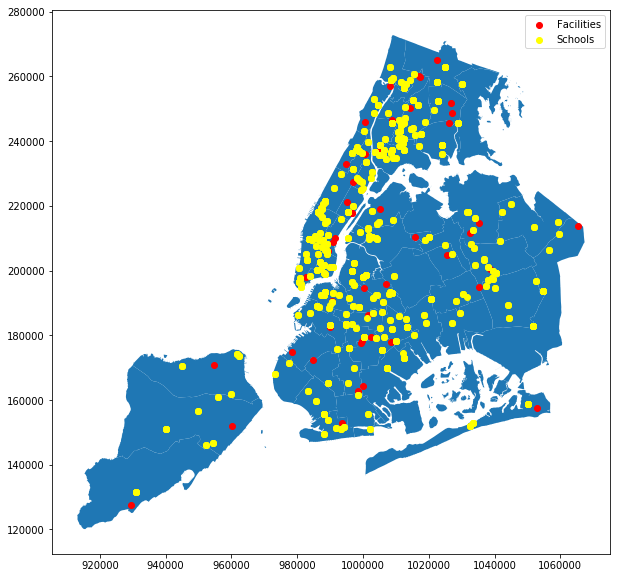

In [52]:
#plot dataframes on the same axes
fig, ax = plt.subplots(figsize=(10, 10))
puma.plot(ax=ax)
geo_fc.plot(c='red', ax=ax, label='Facilities')
geo_sc.plot(c='yellow', ax=ax, label='Schools')
plt.legend()

***Caption [plot of the locations of the facilities and schools]***

## 5.2 Join PUMA and Facilities

In [53]:
#spatial join
facility_puma = gpd.sjoin(puma, geo_fc, op="contains")
facility_puma.head()

,puma,shape_area,shape_leng,geometry,index_right,Permanent Facility Id,asthmaRatio,drugsRatio,facility_id,facility_latitude,facility_longitude,lonlat
1,3702,1.889860e+08,106050.002302,"POLYGON ((1027331.841796877 256069.2766112776,...",1,1168.0,0.018882,0.021711,1168,40.894569,-73.861420,"(-73.86142, 40.894569)"
3,3704,1.062129e+08,47970.901277,"POLYGON ((1026308.769592285 256767.6972045382,...",0,1165.0,0.036560,0.027603,1165,40.857388,-73.846741,"(-73.846741, 40.857388)"
3,3704,1.062129e+08,47970.901277,"POLYGON ((1026308.769592285 256767.6972045382,...",47,3058.0,0.018101,0.002050,3058,40.849575,-73.845055,"(-73.845055, 40.849575)"
5,4016,1.207135e+08,109477.751817,"POLYGON ((999782.7833862281 162246.8424071733,...",10,1293.0,0.007325,0.001209,1293,40.613419,-73.948967,"(-73.948967, 40.613419)"
6,3705,1.224951e+08,68657.316149,"POLYGON ((1019225.58178711 245263.8524169383, ...",4,1176.0,0.029625,0.090146,1176,40.853909,-73.891014,"(-73.891014, 40.853909)"


In [54]:
# the asthmaRatio: ratio of asthma related discharges per puma, averaged by PUMA
# the drugnsRatio: ratio of asthma related discharges per puma, averaged by PUMA

# number of asthma and drug discharges per facility
facility_puma['asthma_count'] = facility_puma['asthmaRatio'] * nyca
facility_puma['drug_count'] = facility_puma['drugsRatio'] * nycd

# group by sum and find ratio
fp_group = facility_puma.groupby('puma', as_index=False).sum()
fp_group['asthmaRatio'] = fp_group['asthma_count'] / nyca
fp_group['drugsRatio'] = fp_group['drug_count'] / nycd
fp_group.head()

,puma,shape_area,shape_leng,index_right,Permanent Facility Id,asthmaRatio,drugsRatio,facility_id,facility_latitude,facility_longitude,asthma_count,drug_count
0,3702,1.889860e+08,106050.002302,1,1168.0,0.018882,0.021711,1168,40.894569,-73.861420,580.0,1006.0
1,3704,2.124257e+08,95941.802554,47,4223.0,0.054660,0.029653,4223,81.706963,-147.691796,1679.0,1374.0
2,3705,1.224951e+08,68657.316149,4,1176.0,0.029625,0.090146,1176,40.853909,-73.891014,910.0,4177.0
3,3706,8.777374e+07,103598.808365,9,2355.0,0.076603,0.010748,2355,81.760463,-147.762100,2353.0,498.0
4,3707,4.228113e+07,37347.925798,5,1178.0,0.043982,0.007273,1178,40.843609,-73.911545,1351.0,337.0


In [55]:
print(facility_puma.shape)
print(fp_group.shape)
print(len(facility_puma.puma.unique()))

(49, 14)
(37, 12)
37


Unique puma districts are picked

## 5.3 Join PUMA and Schools

In [56]:
school_puma = gpd.sjoin(puma, geo_sc, op="contains")
school_puma.head()

,puma,shape_area,shape_leng,geometry,index_right,DBN,SATmath,SATall,school_year,building_code,...,postcode,latitude,longitude,community_board,council_district_,census_tract,bin,bbl,nta,lonlat
0,3701,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,...",551,10X433,371.0,368.666667,2015-16,X430,...,10468.0,40.870293,-73.898309,7.0,11.0,409.0,2015241.0,2.032470e+09,Van Cortlandt Village ...,"(-73.898309, 40.870293)"
0,3701,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,...",550,10X433,371.0,368.666667,2014-15,X430,...,10468.0,40.870293,-73.898309,7.0,11.0,409.0,2015241.0,2.032470e+09,Van Cortlandt Village ...,"(-73.898309, 40.870293)"
0,3701,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,...",549,10X433,371.0,368.666667,2013-14,X430,...,10468.0,40.870293,-73.898309,7.0,11.0,409.0,2015241.0,2.032470e+09,Van Cortlandt Village ...,"(-73.898309, 40.870293)"
0,3701,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,...",537,10X342,333.0,311.333333,2013-14,X430,...,10468.0,40.870293,-73.898309,7.0,11.0,409.0,2015241.0,2.032470e+09,Van Cortlandt Village ...,"(-73.898309, 40.870293)"
0,3701,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,...",538,10X342,333.0,311.333333,2014-15,X430,...,10468.0,40.870293,-73.898309,7.0,11.0,409.0,2015241.0,2.032470e+09,Van Cortlandt Village ...,"(-73.898309, 40.870293)"


In [57]:
# the SATmath and SATall score, averaged by PUMA
# 10 crime related features, each averaged by PUMA
sp_group = school_puma.groupby('puma', as_index=False).mean()
sp_group.head()

,puma,shape_area,shape_leng,index_right,SATmath,SATall,geographical_district_code,#_schools,major_n,oth_n,...,avgofprop_n,avgofvio_n,postcode,latitude,longitude,community_board,council_district_,census_tract,bin,bbl
0,3701,9.792852e+07,53227.144461,551.818182,443.363636,430.363636,10.000000,3.545455,0.030303,0.818182,...,0.813939,0.544242,10466.636364,40.875344,-73.899033,7.363636,11.272727,3014.181818,2.045055e+06,2.037155e+09
1,3702,1.889860e+08,106050.002302,616.333333,378.555556,374.740741,11.000000,5.666667,0.000000,0.000000,...,0.000000,0.000000,10466.666667,40.879912,-73.858878,12.000000,12.000000,382.666667,2.059560e+06,2.047100e+09
2,3703,2.670137e+08,304071.257466,493.400000,394.400000,391.400000,9.200000,5.000000,0.000000,0.000000,...,0.000000,0.000000,10466.600000,40.854058,-73.836689,10.000000,12.600000,18596.800000,2.090891e+06,2.052772e+09
3,3704,1.062129e+08,47970.901277,619.928571,424.428571,414.976190,11.000000,5.642857,0.000000,1.500000,...,0.161429,0.107857,10467.500000,40.857895,-73.861870,11.000000,13.000000,303.428571,2.049886e+06,2.043434e+09
4,3705,1.224951e+08,68657.316149,533.205128,379.115385,374.068376,9.782051,3.794872,0.192308,1.025641,...,0.147692,0.100641,10457.512821,40.842368,-73.894786,4.153846,15.692308,1915.782051,2.018250e+06,2.029639e+09


In [58]:
print(school_puma.shape)
print(sp_group.shape)
print(len(school_puma.puma.unique()))

(1197, 43)
(53, 26)
53


schools are grouped by the unqiue puma districts they are in

# Extra Credit

In [59]:
# get ACS data
API_URL = 'https://fb55.carto.com:443/api/v2/sql?'
query = '''SELECT * FROM fb55.acs16
; '''
table = get_data(query)
table.head(5)

,the_geom,hd02_vd04,the_geom_webmercator,geo_id,geo_id2,geo_display_label,hd01_vd01,hd02_vd01,hd01_vd02,hd02_vd02,...,hd01_vd06,hd02_vd06,hd01_vd07,hd02_vd07,hd01_vd08,hd02_vd08,hd01_vd09,hd02_vd09,hd01_vd10,hd02_vd10
0,NaN,11,NaN,8600000US10464,10464,ZCTA5 10464,4300,587,3262,560,...,0,11,733,439,27,30,2,4,25,29
1,NaN,11,NaN,8600000US10910,10910,ZCTA5 10910,27,41,27,41,...,0,11,0,11,0,11,0,11,0,11
2,NaN,11,NaN,8600000US11430,11430,ZCTA5 11430,179,161,16,30,...,0,11,27,44,7,14,7,14,0,11
3,NaN,11,NaN,8600000US14511,14511,ZCTA5 14511,334,191,316,179,...,0,11,0,11,18,27,0,11,18,27
4,NaN,Margin of Error; Total: - American Indian and ...,NaN,Id,Id2,Geography,Estimate; Total:,Margin of Error; Total:,Estimate; Total: - White alone,Margin of Error; Total: - White alone,...,Estimate; Total: - Native Hawaiian and Other P...,Margin of Error; Total: - Native Hawaiian and ...,Estimate; Total: - Some other race alone,Margin of Error; Total: - Some other race alone,Estimate; Total: - Two or more races:,Margin of Error; Total: - Two or more races:,Estimate; Total: - Two or more races: - Two ra...,Margin of Error; Total: - Two or more races: -...,Estimate; Total: - Two or more races: - Two ra...,Margin of Error; Total: - Two or more races: -...


In [60]:
table.columns

Index(['the_geom', 'hd02_vd04', 'the_geom_webmercator', 'geo_id', 'geo_id2',
       'geo_display_label', 'hd01_vd01', 'hd02_vd01', 'hd01_vd02', 'hd02_vd02',
       'hd01_vd03', 'hd02_vd03', 'hd01_vd04', 'cartodb_id', 'hd01_vd05',
       'hd02_vd05', 'hd01_vd06', 'hd02_vd06', 'hd01_vd07', 'hd02_vd07',
       'hd01_vd08', 'hd02_vd08', 'hd01_vd09', 'hd02_vd09', 'hd01_vd10',
       'hd02_vd10'],
      dtype='object')

# 6 Check Colinearity and Covariance of The Data
## 6.1 SAT Features

In [61]:
sat.head()

,DBN,SATmath,SATall
0,01M292,404.0,374.000000
1,01M448,423.0,390.666667
2,01M450,402.0,383.000000
3,01M458,401.0,391.333333
4,01M509,433.0,402.333333


In [62]:
sat.corr()

,SATmath,SATall
SATmath,1.000000,0.953011
SATall,0.953011,1.000000


SATmath and SATall are strongly correlated

If they are both included in a model, they will introduce strong colinearity

## 6.2 SAT Features vs Crime by PUMA

In [63]:
sp_group.columns

Index(['puma', 'shape_area', 'shape_leng', 'index_right', 'SATmath', 'SATall',
       'geographical_district_code', '#_schools', 'major_n', 'oth_n',
       'nocrim_n', 'prop_n', 'vio_n', 'avgofmajor_n', 'avgofoth_n',
       'avgofnocrim_n', 'avgofprop_n', 'avgofvio_n', 'postcode', 'latitude',
       'longitude', 'community_board', 'council_district_', 'census_tract',
       'bin', 'bbl'],
      dtype='object')

In [64]:
sp_group.head()

,puma,shape_area,shape_leng,index_right,SATmath,SATall,geographical_district_code,#_schools,major_n,oth_n,...,avgofprop_n,avgofvio_n,postcode,latitude,longitude,community_board,council_district_,census_tract,bin,bbl
0,3701,9.792852e+07,53227.144461,551.818182,443.363636,430.363636,10.000000,3.545455,0.030303,0.818182,...,0.813939,0.544242,10466.636364,40.875344,-73.899033,7.363636,11.272727,3014.181818,2.045055e+06,2.037155e+09
1,3702,1.889860e+08,106050.002302,616.333333,378.555556,374.740741,11.000000,5.666667,0.000000,0.000000,...,0.000000,0.000000,10466.666667,40.879912,-73.858878,12.000000,12.000000,382.666667,2.059560e+06,2.047100e+09
2,3703,2.670137e+08,304071.257466,493.400000,394.400000,391.400000,9.200000,5.000000,0.000000,0.000000,...,0.000000,0.000000,10466.600000,40.854058,-73.836689,10.000000,12.600000,18596.800000,2.090891e+06,2.052772e+09
3,3704,1.062129e+08,47970.901277,619.928571,424.428571,414.976190,11.000000,5.642857,0.000000,1.500000,...,0.161429,0.107857,10467.500000,40.857895,-73.861870,11.000000,13.000000,303.428571,2.049886e+06,2.043434e+09
4,3705,1.224951e+08,68657.316149,533.205128,379.115385,374.068376,9.782051,3.794872,0.192308,1.025641,...,0.147692,0.100641,10457.512821,40.842368,-73.894786,4.153846,15.692308,1915.782051,2.018250e+06,2.029639e+09


In [65]:
# crime features: Major N, AvgOfNoCrim N, AvgOfMajor N
crime_features = sp_group[['major_n', 'avgofmajor_n', 'avgofnocrim_n']]
sat_features = sp_group[['puma','SATmath', 'SATall']]

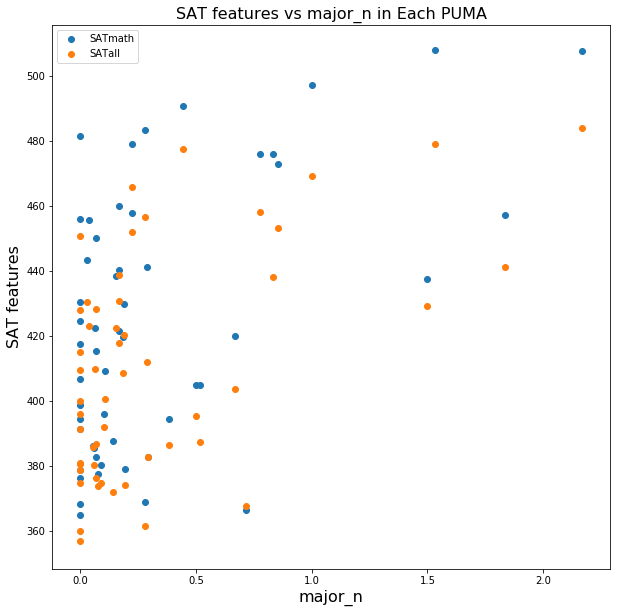

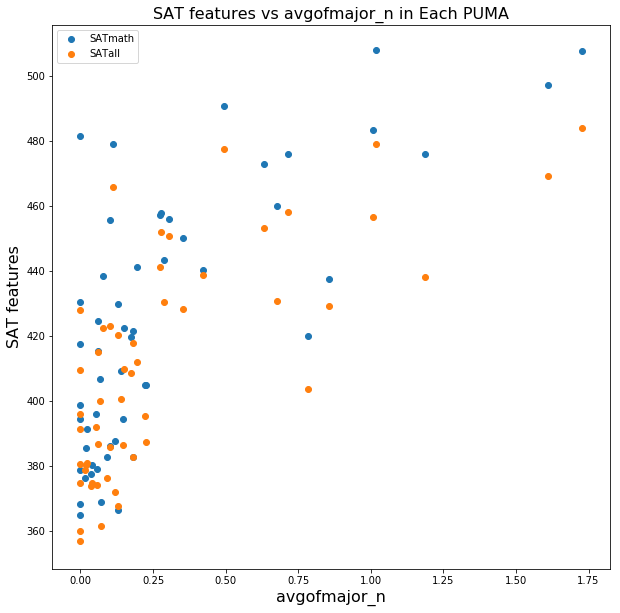

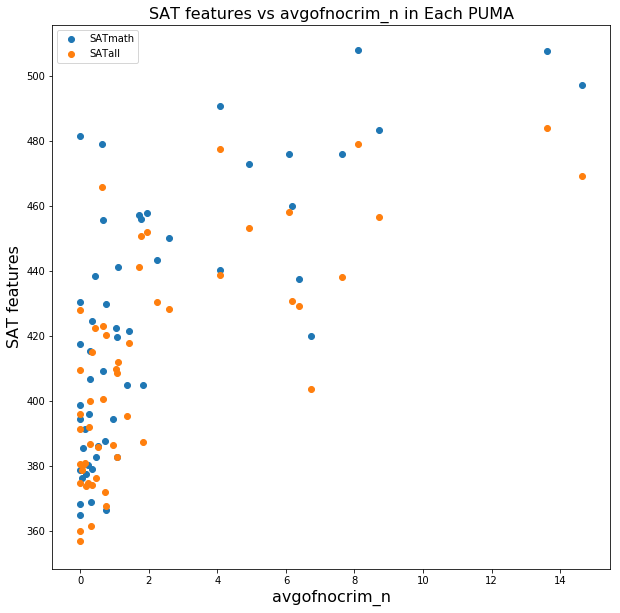

In [66]:
# show plots
for i in crime_features:
    fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(y=sat_features['SATmath'], x=crime_features[i], label='SATmath')
    ax.scatter(y=sat_features['SATall'], x=crime_features[i], label='SATall')
    ax.set_title('SAT features vs %s in Each PUMA'%i, fontsize=16)
    ax.set_xlabel(i, fontsize=16)
    ax.set_ylabel('SAT features', fontsize=16)
    plt.legend()
    plt.show()

***Caption [SAT features does not seem to have clear relationship with major_n and average number of non criminal crimes; there appears to be a relatively clear linear relationship between SAT features and the average number of major crimes]***

In [67]:
# check covariance
temp = pd.concat([crime_features, sat_features], axis=1)
temp.corr()

,major_n,avgofmajor_n,avgofnocrim_n,SATmath,SATall
major_n,1.000000,0.745446,0.710338,0.514197,0.533251
avgofmajor_n,0.745446,1.000000,0.991444,0.706443,0.702843
avgofnocrim_n,0.710338,0.991444,1.000000,0.698878,0.696157
SATmath,0.514197,0.706443,0.698878,1.000000,0.944830
SATall,0.533251,0.702843,0.696157,0.944830,1.000000


## 6.3 SAT Features vs Medical Data

In [68]:
# Medical features: asthmaRatio, drugsRatio
medical_features = fp_group[['puma', 'asthmaRatio', 'drugsRatio']]
ms_merge = pd.merge(sat_features, medical_features, left_on='puma', right_on='puma')
medical_features = ms_merge[['asthmaRatio', 'drugsRatio']]
sat_features = ms_merge[['SATmath', 'SATall']]

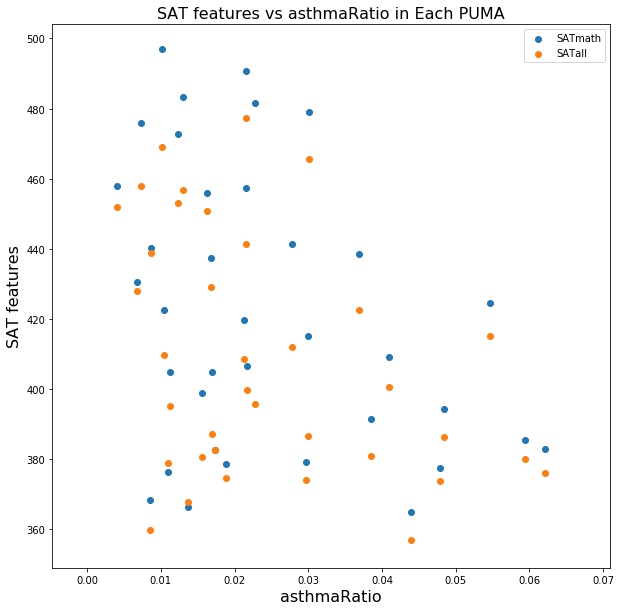

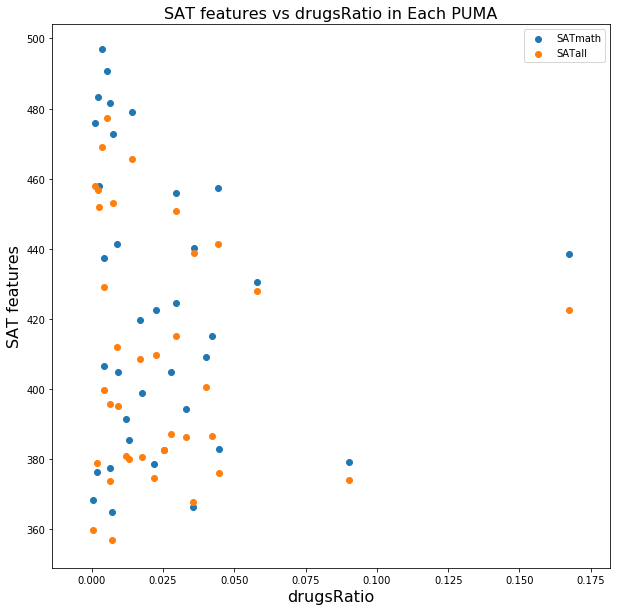

In [69]:
for i in medical_features:
    fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(y=sat_features['SATmath'], x=medical_features[i], label='SATmath')
    ax.scatter(y=sat_features['SATall'], x=medical_features[i], label='SATall')
    ax.set_title('SAT features vs %s in Each PUMA'%i, fontsize=16)
    ax.set_xlabel(i, fontsize=16)
    ax.set_ylabel('SAT features', fontsize=16)
    plt.legend()

***Captions [There appears to be a negative linear relationship between SAT faturs and asthma ratio; there does not seem to be any relationships between SAT features and drugs ratio] ***

In [70]:
# check covariance
temp = pd.concat([medical_features, sat_features], axis=1)
temp.corr()

,asthmaRatio,drugsRatio,SATmath,SATall
asthmaRatio,1.000000,0.234062,-0.354524,-0.383004
drugsRatio,0.234062,1.000000,-0.109341,-0.077552
SATmath,-0.354524,-0.109341,1.000000,0.929744
SATall,-0.383004,-0.077552,0.929744,1.000000


# Extra Credit

In [71]:
sp_group.columns

Index(['puma', 'shape_area', 'shape_leng', 'index_right', 'SATmath', 'SATall',
       'geographical_district_code', '#_schools', 'major_n', 'oth_n',
       'nocrim_n', 'prop_n', 'vio_n', 'avgofmajor_n', 'avgofoth_n',
       'avgofnocrim_n', 'avgofprop_n', 'avgofvio_n', 'postcode', 'latitude',
       'longitude', 'community_board', 'council_district_', 'census_tract',
       'bin', 'bbl'],
      dtype='object')

In [72]:
school_features = sp_group[['major_n', 'oth_n', 'nocrim_n', 'prop_n', 'vio_n', 'avgofmajor_n',
                           'avgofoth_n', 'avgofnocrim_n', 'avgofprop_n', 'avgofvio_n', 'SATmath', 'SATall']]

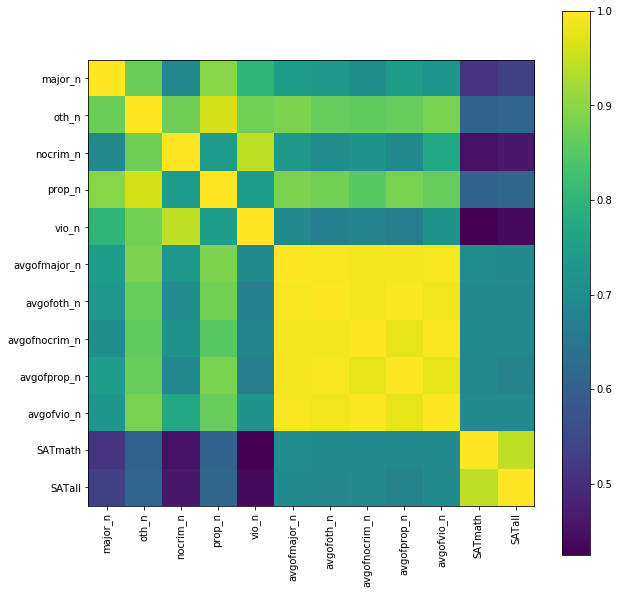

In [73]:
ax = plt.figure(figsize=(10,10)).add_subplot(111)
cax = ax.imshow(school_features.corr())
plt.colorbar(cax)
ax.set_xticks(range(len(school_features.columns)))
ax.set_xticklabels(school_features, rotation=90)
ax.set_yticks(range(len(school_features.columns)))
ax.set_yticklabels(school_features);

***Caption [brighter color suggests higher corrleation. The right diagonal is the correlation of each feature to itself, so it can be ignored. Average number of crimes have strong correlation with each other, and slightly weaker correlation with the SAT features]***

# 7. Mapping

In [74]:
# merge the data together
all_merged = pd.merge(fp_group, sp_group, left_on='puma', right_on='puma')
all_merged = pd.merge(all_merged, puma, left_on='puma', right_on='puma')

all_merged = gpd.GeoDataFrame(all_merged)

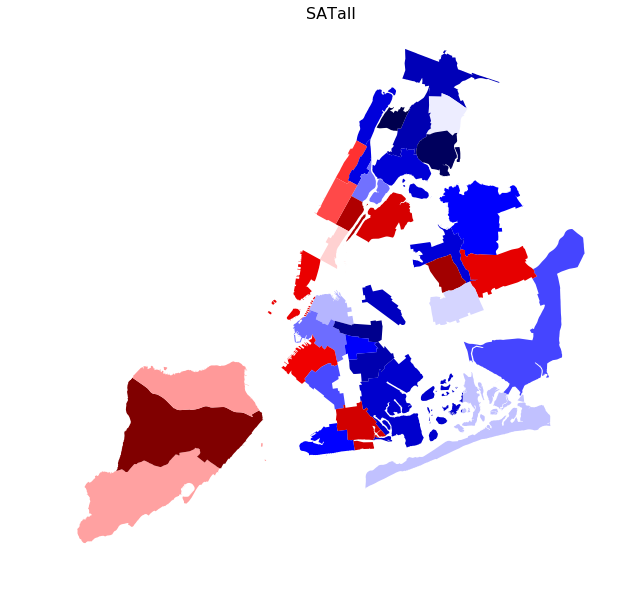

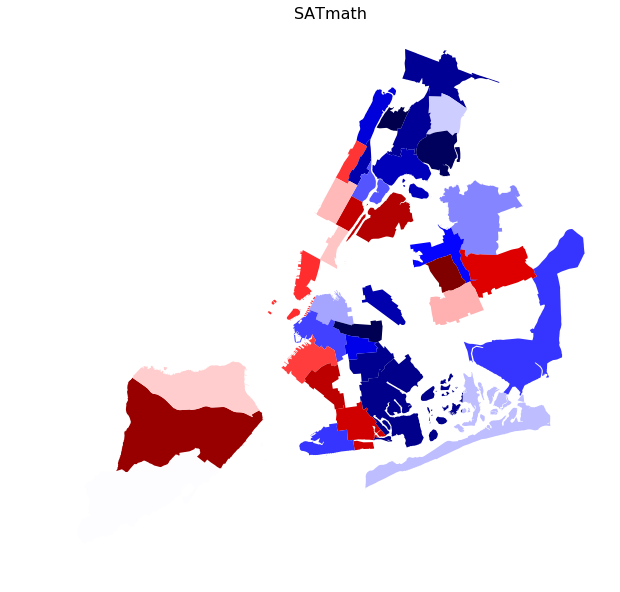

In [75]:
for i in sat_features[['SATall','SATmath']].columns:
    fig, ax = plt.subplots(figsize=(10,10))
    axx = all_merged.plot(column=i, ax=ax, figsize=(10,15), cmap='seismic')
    axx.axis('off')
    axx.set_title(i, fontsize=16)
  

***Caption[Plots the distribution of SAT features, the cmap is seismic so the choropleth is heatmap-like and the reder color indicates that the average score is higher. According to the plots, brooklyn schools have higher math score but lower overall score]***

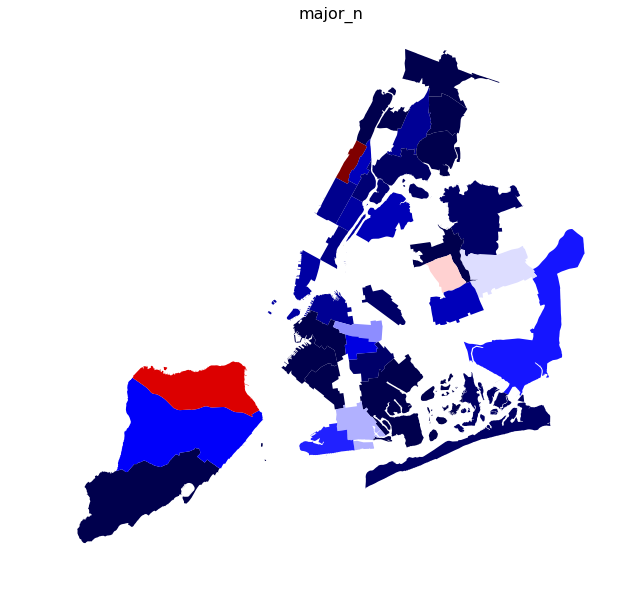

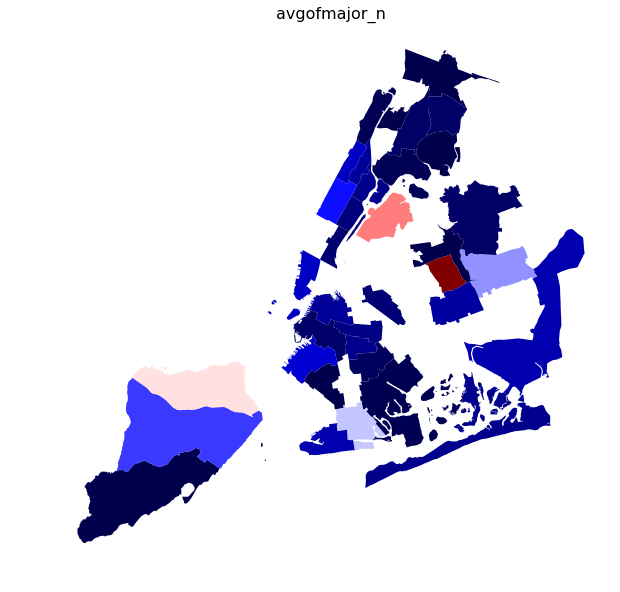

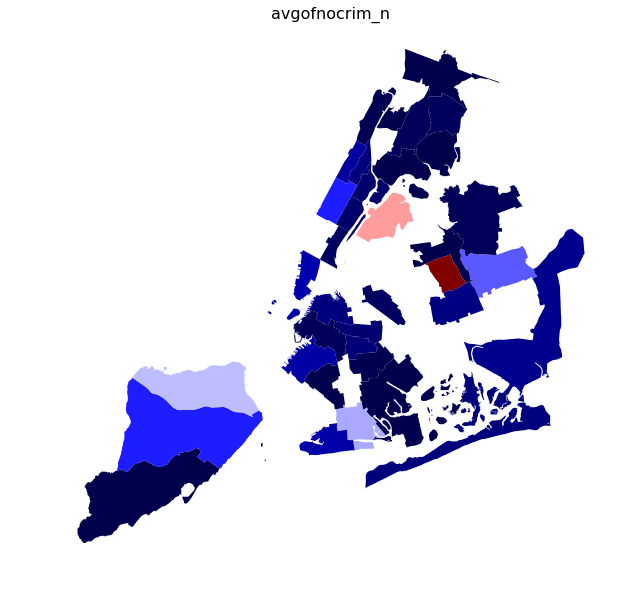

In [76]:
for i in crime_features:
    fig, ax = plt.subplots(figsize=(10, 10))
    axx = all_merged.plot(column=i, ax=ax, cmap='seismic')
    axx.axis('off')
    axx.set_title(i, fontsize=16)

***Caption [The heatmap of crime features by their locations. Crime faetures have similar distributions in NYC]***

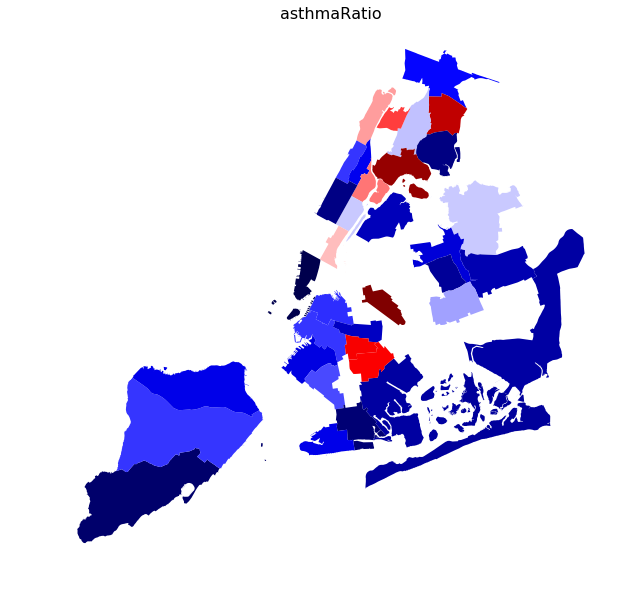

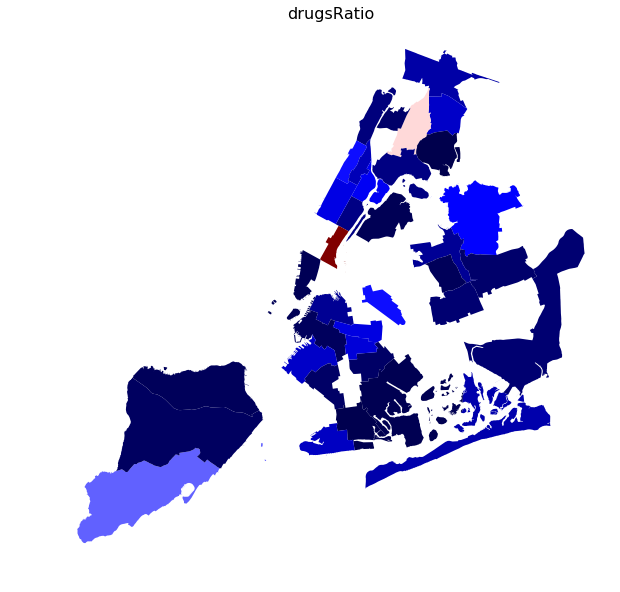

In [77]:
for i in medical_features:
    fig, ax = plt.subplots(figsize=(10, 10))
    axx = all_merged.plot(column=i, ax=ax, cmap='seismic')
    axx.axis('off')
    axx.set_title(i, fontsize=16)

***Captions [Plot of asthma ratio and drug ratio by their puma districts. There are more high asthma ratio areas than high drug ratio areas]***

# 8. Modeling
## 8.1 Model SAT Against Ten Crime Features

In [78]:
# grab the features and normalize
data1 = all_merged[['major_n', 'oth_n', 'nocrim_n', 'prop_n', 'vio_n', 'avgofmajor_n',
                           'avgofoth_n', 'avgofnocrim_n', 'avgofprop_n', 'avgofvio_n', 'SATall']]
scaler = preprocessing.StandardScaler().fit_transform(data1)
data1 = pd.DataFrame(scaler, columns=data1.columns)

# first examine the model with all the data
lm1 = smf.ols(formula='SATall ~ %s'%'+'.join([i for i in data1.columns[:-1]]), data=data1).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATall   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     3.068
Date:                Mon, 17 Dec 2018   Prob (F-statistic):             0.0111
Time:                        22:37:32   Log-Likelihood:                -36.667
No. Observations:                  36   AIC:                             95.33
Df Residuals:                      25   BIC:                             112.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept      5.551e-17      0.134   4.14e-16      1.000        -0.276     0.276
major_n           0.8086      0.672      1.203      0.240        -0.575     2.192
oth_n             2.3561      2.591      0.909      0.372        -2.979     7.692
nocrim_n          0.0827      0.675      0.123      0.903        -1.307     1.473
prop_n           -2.2594      1.861     -1.214      0.236        -6.093     1.574
vio_n            -1.3146      1.217     -1.081      0.290        -3.820     1.191
avgofmajor_n      2.1107      6.922      0.305      0.763       -12.145    16.367
avgofoth_n        0.6082     13.590      0.045      0.965       -27.381    28.598
avgofnocrim_n    -2.5863      3.645     -0.710      0.485       -10.093     4.921
avgofprop_n      -0.4186     12.095     -0.035      0.973       -25.329    24.492
avgofvio_n        1.2110      7.521      0.161      0.873       -14.278    16.700
==============================================================================
Omnibus:                        7.216   Durbin-Watson:                   1.316
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                5.846
Skew:                           0.928   Prob(JB):                       0.0538
Kurtosis:                       3.675   Cond. No.                         425.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

***Evaulation [The model has a r2 of 0.551 and an adjusted r2 of 0.371 which means that the model has explained a small ratio of the variances in the data.]***

## 8.2 Add Discharge Data to the Model

In [79]:
# add discharge data to the features and normalize
data2 = all_merged[medical_features.columns | data1.columns]
scaler = preprocessing.StandardScaler().fit_transform(data2)
data2 = pd.DataFrame(scaler, columns=data2.columns)

# first examine the model with all the data
lm2 = smf.ols(formula='SATall ~ %s'%'+'.join([i for i in data2.columns[1:]]), data=data2).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATall   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     2.589
Date:                Mon, 17 Dec 2018   Prob (F-statistic):             0.0241
Time:                        22:37:32   Log-Likelihood:                -35.696
No. Observations:                  36   AIC:                             97.39
Df Residuals:                      23   BIC:                             118.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept      5.551e-17      0.136   4.08e-16      1.000        -0.281     0.281
asthmaRatio      -0.1327      0.162     -0.820      0.421        -0.468     0.202
avgofmajor_n      3.5623      7.142      0.499      0.623       -11.213    18.337
avgofnocrim_n    -3.1269      3.747     -0.834      0.413       -10.879     4.625
avgofoth_n        3.4977     14.051      0.249      0.806       -25.569    32.564
avgofprop_n      -2.8349     12.482     -0.227      0.822       -28.656    22.986
avgofvio_n       -0.2783      7.751     -0.036      0.972       -16.313    15.757
drugsRatio        0.1337      0.147      0.907      0.374        -0.171     0.439
major_n           0.6324      0.706      0.896      0.380        -0.828     2.093
nocrim_n          0.0838      0.703      0.119      0.906        -1.370     1.538
oth_n             2.2049      2.633      0.837      0.411        -3.242     7.652
prop_n           -2.0011      1.913     -1.046      0.306        -5.958     1.956
vio_n            -1.1580      1.249     -0.927      0.364        -3.742     1.426
==============================================================================
Omnibus:                        8.464   Durbin-Watson:                   1.615
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                7.188
Skew:                           0.908   Prob(JB):                       0.0275
Kurtosis:                       4.223   Cond. No.                         439.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

***Evaluate [The r2 value increases, which is expected since there are more featuers added to the model. Criminal features seem to have a stronger effects in the model]***

***Comparison [Asthma ratio and drugs ratio have very insignificant effects on the model]***

# 9. Compare The Models

In [80]:
# use lr test to compare two models
# the null hypothesis is that the first linear model, with only school data
# is better than the second model that contains the discharge data
lm2.compare_lr_test(lm1)

(1.9413417652817344, 0.37882880316412737, 2.0)

H0: lm1 is better than lm2

Ha: lm1 is not better than lm2

The p-value for 2 degrees of freedom is 5.991 with significance level of 0.05

Since returned pvalue < 5.991, H0 cannot be rejected

lm1 is better than lm2 cannot be rejected, but it does not mean that lm2 is better than lm1

This can be explained by the fact that asthmaRatio and drugsRatio have small coefs, they make very small impact to the model

# 10. Random Forest Regression
## 10.1 Use 10 Crime Features

In [81]:
# take data and normalize 
rfdata = sat_crime[data1.columns[:-1] | ['SATall']]
scalar = preprocessing.StandardScaler().fit_transform(rfdata)
rfdata = pd.DataFrame(scalar, columns=rfdata.columns)

# train the model
trainX, testX, trainy, testy = train_test_split(rfdata.drop('SATall', axis=1), rfdata.SATall, test_size=0.3)
rfmodel = rfr(n_estimators=500, max_features=2, random_state=0)  
rfmodel.fit(trainX, trainy)  
y_pred = rfmodel.predict(testX) 

# show test scores
print('r2 is: ', rfmodel.score(trainX, trainy))
print('r2 os: ', rfmodel.score(testX, testy))
print('MSE: ', metrics.mean_squared_error(testy, y_pred))  

r2 is:  0.591184782323
r2 os:  0.415874776425
MSE:  0.598982112355


The in sample r2 is ok, but the out sample r2 indicates that the model have lower predictive power

## 10.2 Choose 3 Most Predictive Features

In [82]:
'''Professors function, with a little change'''
def featureImportancePlot(rf, labels):
    '''plots feature importance for random forest
    rf: the random forest model fit to the data
    labels: the names of the features
    '''
    
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)


    plt.figure(figsize=(10,10))
    plt.title("Feature importances")
    plt.bar(range(indices.shape[0]), rf.feature_importances_[indices],
       color="SteelBlue", yerr=std[indices], align="center")
    plt.xticks(range(indices.shape[0]), np.array(labels)[indices], rotation=90)
    plt.xlim([-1, indices.shape[0]])
    plt.show()

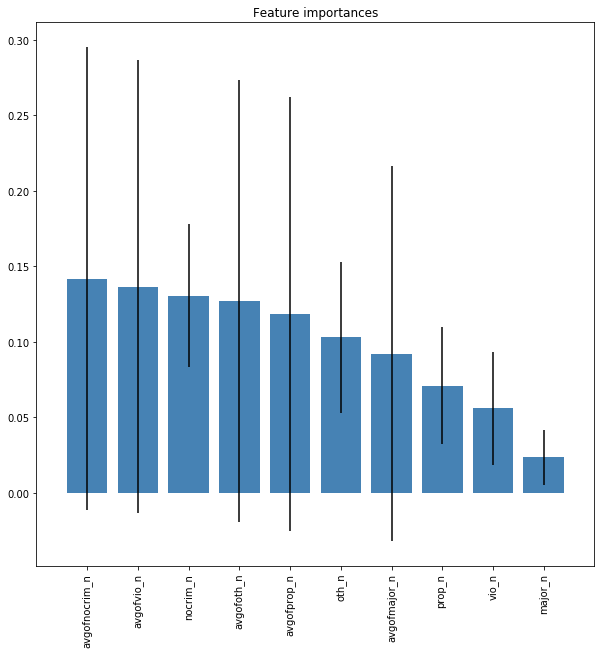

In [83]:
featureImportancePlot(rfmodel, trainX.columns)

***Caption [Box plot of the features by their importance]***

# 11 Random Forest Regression with Crime and Medical Features
## 11.1 Model with Most Predictive Features from #10 and Medical Features

In [84]:
# dictionary of feature importance
v = rfmodel.feature_importances_
k = rfdata.drop('SATall', axis=1).columns
dic = {}
for i,j in zip(k,v):
    dic[i] = j
sorted_dic = sorted(dic.items(), key=lambda kv: kv[1])
sorted_dic

[('major_n', 0.023549644793132471),
 ('vio_n', 0.055848314471359843),
 ('prop_n', 0.071013486330490552),
 ('avgofmajor_n', 0.092118189247881427),
 ('oth_n', 0.10285521294275775),
 ('avgofprop_n', 0.11869149760689035),
 ('avgofoth_n', 0.12715299772764158),
 ('nocrim_n', 0.13041575201531472),
 ('avgofvio_n', 0.13650830513726966),
 ('avgofnocrim_n', 0.14184659972726155)]

In [85]:
data3 = all_merged[['SATall', sorted_dic[-1][0], sorted_dic[-2][0], sorted_dic[-3][0], 'asthmaRatio', 'drugsRatio']]
scalar = preprocessing.StandardScaler().fit_transform(data3)
data3 = pd.DataFrame(scalar, columns=data3.columns)


# train the model
trainX, testX, trainy, testy = train_test_split(data3.drop('SATall', axis=1), data3.SATall, test_size=0.3)
rfmodel = rfr(n_estimators=500, max_features=2, random_state=0)  
rfmodel.fit(trainX, trainy)  
y_pred = rfmodel.predict(testX) 

# show test scores
print('r2 is: ', rfmodel.score(trainX, trainy))
print('r2 os: ', rfmodel.score(testX, testy))
print('MSE: ', metrics.mean_squared_error(testy, y_pred))  

r2 is:  0.893273913235
r2 os:  0.604208040431
MSE:  0.484313068926


## 11.2 Evaluate the Model

The model's r square value improved significantly but the out sample r square value is still lower

The model is manually tuned at random state 0:

    higher n_estimators will give better performance, but will also take longer, 500 is good enough
    
    max_features is the max number of features to cosider at each split, it is tested from 1 to 4
    
generally, the out sample r2 will not pass 0.6, and the in sample r2 is around 0.9

## 11.3 Importance of Each Feature

In [86]:
l1 = rfmodel.feature_importances_
l2 = trainX.columns

In [87]:
# dictionary of feature importance
v = rfmodel.feature_importances_
k = data3.drop('SATall', axis=1).columns
dic = {}
for i,j in zip(k,v):
    dic[i] = j
sorted_dic = sorted(dic.items(), key=lambda kv: kv[1])
sorted_dic

[('drugsRatio', 0.12054771192053672),
 ('asthmaRatio', 0.16666488942683994),
 ('avgofnocrim_n', 0.20467274129679139),
 ('nocrim_n', 0.24731845207593878),
 ('avgofvio_n', 0.260796205279893)]

The crime features have larger impact on the model than the medical features